In [16]:
# !/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxx------------FIT GAUSSIAN PROFILES TO SUPERNOVA SPECTRA----------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import sys
import numpy as np
import pandas as pd
import uncertainties as unc
from astropy.io import fits
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit, fsolve

import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.ticker import MultipleLocator
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
# Constants
light_speed = 2.99792458e5
norm_factor = 1e-15
parsec = 3.086e18
ev = 1.602e-12
kB = 1.38e-16

# Supernova
dist = 16.45e6
mni = 0.033

# File and Directory path
file_name = 'rrfz_2021-02-21_2020jfo.dat'
DIR_SPEC = '/home/avinash/Supernovae_Data/2020jfo/Spectroscopy/DOT/'
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plot Confidence Intervals
# Function For Setting Plot Parameters And Plotting
# ------------------------------------------------------------------------------------------------------------------- #

def plot_confintervals(ax_obj, optpar, covpar, xarr, fcolor='orange', components=5):
    """
    Plots 3-Sigma Confidence Intervals in Fits of SN Parameters.
    Args:
        ax_obj     : Axes object on which the confidence interval is to be plotted
        optpar     : Optimised Parameters of the Fit
        covpar     : Covariance Parameters of the Fit
        xarr       : Array of X-Values over which confidence intervals are to be plotted
        fcolor     : Fill color for the confidence intervals
        components : Number of gaussian components in the fit
    Returns:
        None
    """
    def err(xarr, h, c, w):
        return h * unp.exp(-(xarr - c) ** 2 / (2 * w ** 2))

    if components == 5:
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + \
               err(xarr, h4, c4, w1) + err(xarr, h5, c5, w1) + offset
    elif components == 2:
        h1, c1, w1, h2, c2, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + offset
    elif components == 8:
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + \
               err(xarr, h4, c4, w1) + err(xarr, h5, c5, w1) + err(xarr, h6, c6, w1) + \
               err(xarr, h7, c7, w1) + err(xarr, h8, c8, w1) + offset
    elif components == 'CaIISingle':
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + \
               err(xarr, h4, c4, w1) + err(xarr, h5, c5, w1) + err(xarr, h6, c6, w1) + \
               err(xarr, h7, c7, w1) + err(xarr, h8, c8, w1) + err(xarr, h9, c9, w1) + offset
    elif components == 'CaIIDouble':
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, w2, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w2) + \
               err(xarr, h4, c4, w2) + err(xarr, h5, c5, w2) + err(xarr, h6, c6, w2) + \
               err(xarr, h7, c7, w2) + err(xarr, h8, c8, w2) + err(xarr, h9, c9, w2) + offset
    elif components == 'CaIITriple':
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, w2, w3, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w2) + \
               err(xarr, h4, c4, w2) + err(xarr, h5, c5, w3) + err(xarr, h6, c6, w3) + \
               err(xarr, h7, c7, w3) + err(xarr, h8, c8, w3) + err(xarr, h9, c9, w3) + offset
        
    fit = unp.nominal_values(func)
    sigma = unp.std_devs(func)

    fitlow = fit - 3 * sigma
    fithigh = fit + 3 * sigma

    ax_obj.plot(xarr, fitlow, ls='-.', c='k', lw=0.7, alpha=0.7, label='_nolegend_')
    ax_obj.plot(xarr, fithigh, ls='-.', c='k', lw=0.7, alpha=0.7, label='_nolegend_')
    ax_obj.fill_between(xarr, fitlow, fithigh, facecolor=fcolor, alpha=0.4)


def set_plotparams(ax_obj, xticks=(50, 5), yticks=(1, 0.1), grid=True, legend=False, fs=14, ms=1.5):
    """
    Sets plot parameters to the axes object 'ax_obj'.
    Args:
        ax_obj      : Axes object to be used for plotting and setting plot parameters
        xticks      : X-Axis Major and Minor tick intervals
        yticks      : Y-Axis Major and Minor tick intervals
        grid        : Boolean stating whether to enable Grid in the plot
        legend      : Boolean stating whether legend is to be displayed in the plot
        fs          : Font of the labels in the legend
        ms          : Scaled marker size to be used in the legend
    Returns:
    """
    if legend:
        handles, labels = ax_obj.get_legend_handles_labels()
        handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
        ax_obj.legend(handles, labels, fontsize=fs, markerscale=ms, frameon=False)

    if grid:
        ax_obj.grid(True, which='major', ls='--', lw=1, alpha=0.7)

    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, color='k', 
                       labelcolor='k', labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, color='k', 
                       labelcolor='k', labelsize=fs)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Mathematical Functions used in Fitting
# ------------------------------------------------------------------------------------------------------------------- #

def gaussian(x, height, center, width, offset):
    return height * np.exp(-(x - center) ** 2 / (2 * (width ** 2))) + offset


def two_gaussians(x, h1, c1, h2, c2, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) + offset)


def five_gaussians(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + gaussian(x, h4, c4, w1, offset=0) + 
            gaussian(x, h5, c5, w1, offset=0) + offset)


def eight_gaussians(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + gaussian(x, h4, c4, w1, offset=0) + 
            gaussian(x, h5, c5, w1, offset=0) + gaussian(x, h6, c6, w1, offset=0) + 
            gaussian(x, h7, c7, w1, offset=0) + gaussian(x, h8, c8, w1, offset=0) + offset)


def fit_caiisingle(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + gaussian(x, h4, c4, w1, offset=0) + 
            gaussian(x, h5, c5, w1, offset=0) + gaussian(x, h6, c6, w1, offset=0) + 
            gaussian(x, h7, c7, w1, offset=0) + gaussian(x, h8, c8, w1, offset=0) + 
            gaussian(x, h9, c9, w1, offset=0) + offset)


def fit_caiidouble(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, w2, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w2, offset=0) + gaussian(x, h4, c4, w2, offset=0) + 
            gaussian(x, h5, c5, w2, offset=0) + gaussian(x, h6, c6, w2, offset=0) + 
            gaussian(x, h7, c7, w2, offset=0) + gaussian(x, h8, c8, w2, offset=0) + 
            gaussian(x, h9, c9, w2, offset=0) + offset)


def fit_caiitriple(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, h6, c6, h7, c7, h8, c8, h9, c9, w1, w2, w3, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w2, offset=0) + gaussian(x, h4, c4, w2, offset=0) + 
            gaussian(x, h5, c5, w3, offset=0) + gaussian(x, h6, c6, w3, offset=0) + 
            gaussian(x, h7, c7, w3, offset=0) + gaussian(x, h8, c8, w3, offset=0) + 
            gaussian(x, h9, c9, w3, offset=0) + offset)

# ------------------------------------------------------------------------------------------------------------------- #



# ------------------------------------------------------------------------------------------------------------------- #
# Functions used for Fitting and Computing Line Flux
# ------------------------------------------------------------------------------------------------------------------- #

def fit_feature(feature, func=five_gaussians):
    wave_lim = wave_range.split(',')
    lower_lim = int(wave_lim[0])
    upper_lim = int(wave_lim[1])

    flux = flux_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]
    wav = wav_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]

    fit_wav = np.arange(min(wav), max(wav), 1)
    fit_vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in fit_wav])
    vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in wav])

    opt, cov = curve_fit(func, wav, flux, bounds=(boundlow, boundhigh))
    err = np.sqrt(np.diag(cov))
    
    return wav, flux, fit_wav, opt, cov, err


def calc_flux(opt, err, norm_factor):
    (h, _, w, _) = opt
    (herr, _, werr, _) = err
    flux = (h * w * (2 * np.pi) ** 0.5) * norm_factor
    fluxerr = flux * ((herr / h) ** 2 + (werr / w) ** 2) ** 0.5
    return flux, fluxerr
    

def calc_ejectatemp(temp, lineflux, mni):
    linelum = lineflux * 4.0 * np.pi * ((dist * parsec) ** 2)
    return (15 + 0.006 * temp) - ((8.67e43 / linelum) * mni) * np.exp(-(1.96 * ev) / (kB * temp))


def calc_niferatio(niflux, feiiflux, temp):
    return (niflux / (4.9 * feiiflux)) * np.exp(-0.28 * ev / (kB * temp))

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Read Data From The Spectrum to be Fitted
# ------------------------------------------------------------------------------------------------------------------- #
data_df = pd.read_csv(DIR_SPEC + file_name, sep='\s+', header=None, names=['Wavelength', 'Flux'], comment='#')
wav_data = np.array(data_df['Wavelength'])
flux_data = np.array(data_df['Flux']) / norm_factor
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Choose Region For Fitting & Fit The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
dict_20jfo = {8: (7300, '7020,7520', eight_gaussians,
                      [0.10, 7291, 0.10, 7324, 0.10, 7378, 0.10, 7410, 0.10, 7455, 0.10, 7155, 0.10, 7172, 0.10, 7065, 13, 0.01],
                      [0.02, 7285, 0.02, 7320, 0.02, 7370, 0.02, 7400, 0.02, 7445, 0.02, 7135, 0.02, 7165, 0.02, 7055, 5, 0.005],
                      [0.35, 7295, 0.35, 7325, 0.35, 7385, 0.35, 7420, 0.15, 7465, 0.20, 7175, 0.20, 7180, 0.20, 7070, 20, 0.016]),
              'CaIISingle': (7300, '7020,7520', fit_caiisingle,
                      [0.10, 7291, 0.10, 7324, 0.10, 7378, 0.05, 7412, 0.04, 7453, 0.05, 7155, 0.05, 7172, 0.05, 7065, 0.05, 7388, 13, 0.01],
                      [0.02, 7281, 0.02, 7324, 0.02, 7360, 0.01, 7402, 0.01, 7448, 0.01, 7145, 0.01, 7162, 0.01, 7055, 0.02, 7378, 5, 0.005],
                      [0.35, 7301, 0.35, 7334, 0.35, 7398, 0.35, 7422, 0.35, 7463, 0.30, 7165, 0.30, 7180, 0.30, 7075, 0.30, 7398, 25, 0.016]),
              'CaIIDouble': (7300, '7000,7520', fit_caiidouble,
                      [0.10, 7291, 0.10, 7324, 0.10, 7378, 0.05, 7412, 0.04, 7453, 0.05, 7155, 0.05, 7172, 0.05, 7065, 0.05, 7388, 13, 13, 0.01],
                      [0.02, 7281, 0.02, 7324, 0.02, 7360, 0.01, 7402, 0.01, 7448, 0.01, 7145, 0.01, 7162, 0.01, 7055, 0.02, 7378, 5, 5, 0.005],
                      [0.35, 7301, 0.35, 7334, 0.35, 7398, 0.35, 7422, 0.35, 7463, 0.30, 7162, 0.30, 7182, 0.30, 7075, 0.30, 7398, 25, 25, 0.016]),
              'CaIITriple': (7300, '7020,7520', fit_caiitriple,
                      [0.10, 7291, 0.10, 7324, 0.10, 7378, 0.05, 7412, 0.04, 7453, 0.05, 7155, 0.05, 7172, 0.05, 7065, 0.05, 7388, 13, 13, 13, 0.01],
                      [0.01, 7286, 0.01, 7319, 0.01, 7371, 0.01, 7402, 0.01, 7448, 0.01, 7145, 0.01, 7162, 0.01, 7055, 0.01, 7380, 5, 5, 5, 0.005],
                      [0.35, 7296, 0.35, 7329, 0.35, 7385, 0.35, 7422, 0.35, 7463, 0.30, 7165, 0.30, 7180, 0.30, 7075, 0.30, 7395, 25, 25, 25, 0.016])}

# ------------------------------------------------------------------------------------------------------------------- #


[0.225, 7293.195, 20.0, 0.016] [0.024, 2.052, 1.069, 0.005]
[0.192, 7323.728, 20.0, 0.016] [0.023, 3.199, 1.069, 0.005]
[0.219, 7375.358, 20.0, 0.016] [0.009, 1.781, 1.069, 0.005]
[0.112, 7420.0, 20.0, 0.016] [0.01, 3.868, 1.069, 0.005]
[0.054, 7465.0, 20.0, 0.016] [0.009, 5.219, 1.069, 0.005]
[0.098, 7144.399, 20.0, 0.016] [0.013, 3.09, 1.069, 0.005]
[0.075, 7180.0, 20.0, 0.016] [0.012, 4.113, 1.069, 0.005]
[0.077, 7070.0, 20.0, 0.016] [0.008, 1.931, 1.069, 0.005]
----------------------------------------
[CaII]-7291 = 1.13e-14+/-1.30e-15
[CaII]-7324 = 9.63e-15+/-1.26e-15
[NiII]-7378 = 1.10e-14+/-7.40e-16
[NiII]-7412 = 5.61e-15+/-5.84e-16
[FeII]-7155 = 4.91e-15+/-7.03e-16
[FeII]-7172 = 3.76e-15+/-6.34e-16
[NiII] 7412/7378 = 0.51
[FeII] 7172/7155 = 0.77
[NiII]7378 / [FeII]7155 = 2.23
[NiII/FeII] Ratio = 0.19
----------------------------------------


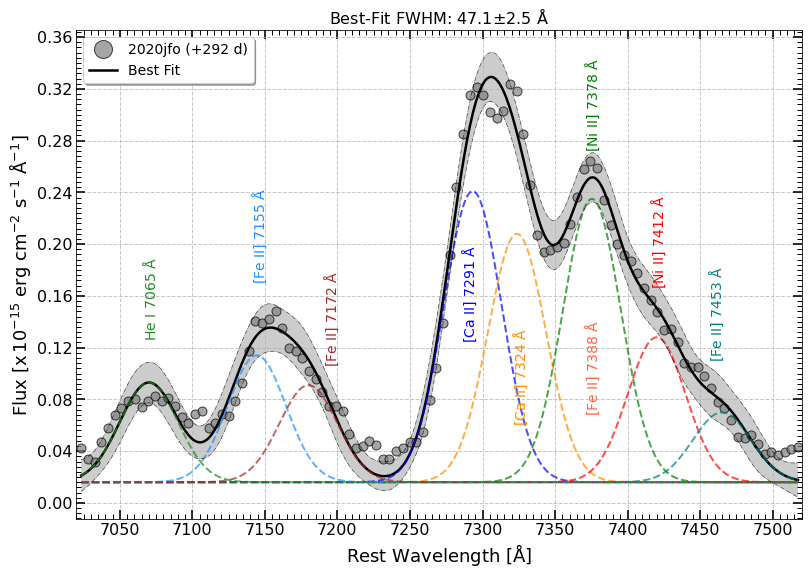

In [8]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
feature = 8
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 16, 17]]
err1 = [round(err[index], 3) for index in [0, 1, 16, 17]]
opt2 = [round(opt[index], 3) for index in [2, 3, 16, 17]]
err2 = [round(err[index], 3) for index in [2, 3, 16, 17]]
opt3 = [round(opt[index], 3) for index in [4, 5, 16, 17]]
err3 = [round(err[index], 3) for index in [4, 5, 16, 17]]
opt4 = [round(opt[index], 3) for index in [6, 7, 16, 17]]
err4 = [round(err[index], 3) for index in [6, 7, 16, 17]]
opt5 = [round(opt[index], 3) for index in [8, 9, 16, 17]]
err5 = [round(err[index], 3) for index in [8, 9, 16, 17]]
opt6 = [round(opt[index], 3) for index in [10, 11, 16, 17]]
err6 = [round(err[index], 3) for index in [10, 11, 16, 17]]
opt7 = [round(opt[index], 3) for index in [12, 13, 16, 17]]
err7 = [round(err[index], 3) for index in [12, 13, 16, 17]]
opt8 = [round(opt[index], 3) for index in [14, 15, 16, 17]]
err8 = [round(err[index], 3) for index in [14, 15, 16, 17]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)
print (opt4, err4)
print (opt5, err5)
print (opt6, err6)
print (opt7, err7)
print (opt8, err8)

ca7291 = calc_flux(opt1, err2, norm_factor)
ca7324 = calc_flux(opt2, err2, norm_factor)
ni7378 = calc_flux(opt3, err3, norm_factor)
ni7412 = calc_flux(opt4, err4, norm_factor)
fe7155 = calc_flux(opt6, err6, norm_factor)
fe7172 = calc_flux(opt7, err7, norm_factor)
temp = fsolve(calc_ejectatemp, x0 = 4000, args = (fe7155[0], mni))[0]
niferatio = calc_niferatio(ni7378[0], fe7155[0], temp)

print ("-" * 40)
print ("[CaII]-7291 = {0:.2e}+/-{1:.2e}".format(*ca7291))
print ("[CaII]-7324 = {0:.2e}+/-{1:.2e}".format(*ca7324))
print ("[NiII]-7378 = {0:.2e}+/-{1:.2e}".format(*ni7378))
print ("[NiII]-7412 = {0:.2e}+/-{1:.2e}".format(*ni7412))
print ("[FeII]-7155 = {0:.2e}+/-{1:.2e}".format(*fe7155))
print ("[FeII]-7172 = {0:.2e}+/-{1:.2e}".format(*fe7172))
print ("[NiII] 7412/7378 = {0:.2f}".format(ni7412[0]/ni7378[0]))
print ("[FeII] 7172/7155 = {0:.2f}".format(fe7172[0]/fe7155[0]))
print ("[NiII]7378 / [FeII]7155 = {0:.2f}".format(ni7378[0]/fe7155[0]))
print ("[NiII/FeII] Ratio = {0:.2f}".format(niferatio))
print ("-" * 40)

fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+292 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Best Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='darkorange', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='g', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt4), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt5), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt6), lw=2, ls='--', alpha=0.7, c='dodgerblue', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt7), lw=2, ls='--', alpha=0.7, c='brown', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt8), lw=2, ls='--', alpha=0.7, c='forestgreen', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=feature)

# ax.set_yticklabels([])
ax.set_xlim(7020, 7520)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.04, 0.004), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM: {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)

ax.text(0.09, 0.37, r"$\rm He\ I\ 7065\ \AA$", fontsize=14, color='forestgreen', rotation=90, transform=ax.transAxes)
ax.text(0.24, 0.49, r"$\rm [Fe\ II]\ 7155\ \AA$", fontsize=14, color='dodgerblue', rotation=90, transform=ax.transAxes)
ax.text(0.34, 0.32, r"$\rm [Fe\ II]\ 7172\ \AA$", fontsize=14, color='brown', rotation=90, transform=ax.transAxes)
ax.text(0.53, 0.37, r"$\rm [Ca\ II]\ 7291\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.60, 0.20, r"$\rm [Ca\ II]\ 7324\ \AA$", fontsize=14, color='darkorange', rotation=90, transform=ax.transAxes)
ax.text(0.70, 0.76, r"$\rm [Ni\ II]\ 7378\ \AA$", fontsize=14, color='g', rotation=90, transform=ax.transAxes)
ax.text(0.70, 0.22, r"$\rm [Fe\ II]\ 7388\ \AA$", fontsize=14, color='tomato', rotation=90, transform=ax.transAxes)
ax.text(0.79, 0.48, r"$\rm [Ni\ II]\ 7412\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.87, 0.33, r"$\rm [Fe\ II]\ 7453\ \AA$", fontsize=14, color='teal', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_CaIINiIIFit8Comp.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### 9-Component Fit (Keeping line broadening of all features same)

[0.264, 7301.0, 23.721, 0.016] [0.416, 17.45, 3.483, 0.01]
[0.079, 7324.0, 23.721, 0.016] [0.276, 123.733, 3.483, 0.01]
[0.186, 7375.338, 23.721, 0.016] [1058.107, 7580.919, 3.483, 0.01]
[0.085, 7422.0, 23.721, 0.016] [0.23, 62.269, 3.483, 0.01]
[0.045, 7463.0, 23.721, 0.016] [0.049, 20.651, 3.483, 0.01]
[0.09, 7147.273, 23.721, 0.016] [0.032, 9.027, 3.483, 0.01]
[0.06, 7180.0, 23.721, 0.016] [0.034, 10.808, 3.483, 0.01]
[0.071, 7068.799, 23.721, 0.016] [0.01, 2.621, 3.483, 0.01]
[0.02, 7378.0, 23.721, 0.016] [1058.052, 71018.385, 3.483, 0.01]
----------------------------------------
[CaII]-7291 = 1.57e-14+/-1.66e-14
[CaII]-7324 = 4.70e-15+/-1.64e-14
[NiII]-7378 = 1.11e-14+/-6.29e-11
[NiII]-7412 = 5.05e-15+/-1.37e-14
[FeII]-7155 = 5.35e-15+/-2.06e-15
[FeII]-7172 = 3.57e-15+/-2.09e-15
[NiII] 7412/7378 = 0.46
[FeII] 7172/7155 = 0.67
[NiII]7378 / [FeII]7155 = 2.07
[NiII/FeII] Ratio = 0.18
----------------------------------------


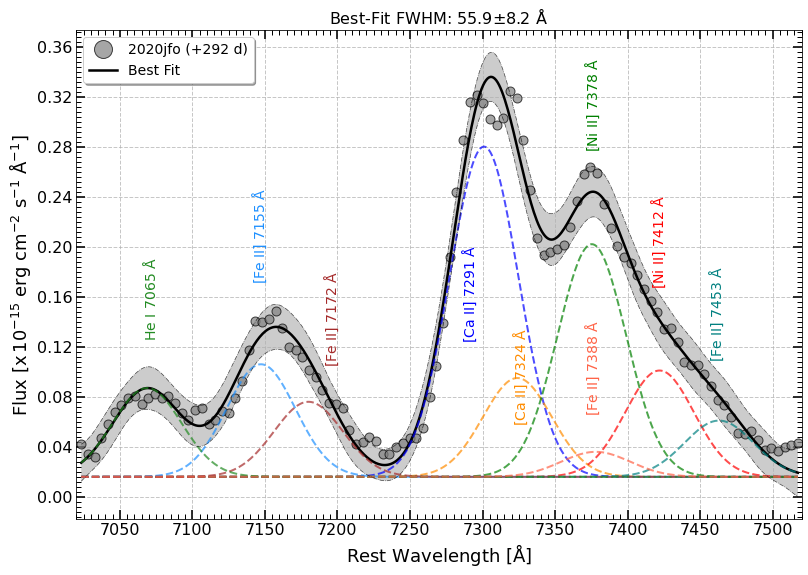

In [9]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
feature = 'CaIISingle'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 18, 19]]
err1 = [round(err[index], 3) for index in [0, 1, 18, 19]]
opt2 = [round(opt[index], 3) for index in [2, 3, 18, 19]]
err2 = [round(err[index], 3) for index in [2, 3, 18, 19]]
opt3 = [round(opt[index], 3) for index in [4, 5, 18, 19]]
err3 = [round(err[index], 3) for index in [4, 5, 18, 19]]
opt4 = [round(opt[index], 3) for index in [6, 7, 18, 19]]
err4 = [round(err[index], 3) for index in [6, 7, 18, 19]]
opt5 = [round(opt[index], 3) for index in [8, 9, 18, 19]]
err5 = [round(err[index], 3) for index in [8, 9, 18, 19]]
opt6 = [round(opt[index], 3) for index in [10, 11, 18, 19]]
err6 = [round(err[index], 3) for index in [10, 11, 18, 19]]
opt7 = [round(opt[index], 3) for index in [12, 13, 18, 19]]
err7 = [round(err[index], 3) for index in [12, 13, 18, 19]]
opt8 = [round(opt[index], 3) for index in [14, 15, 18, 19]]
err8 = [round(err[index], 3) for index in [14, 15, 18, 19]]
opt9 = [round(opt[index], 3) for index in [16, 17, 18, 19]]
err9 = [round(err[index], 3) for index in [16, 17, 18, 19]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)
print (opt4, err4)
print (opt5, err5)
print (opt6, err6)
print (opt7, err7)
print (opt8, err8)
print (opt9, err9)

ca7291 = calc_flux(opt1, err2, norm_factor)
ca7324 = calc_flux(opt2, err2, norm_factor)
ni7378 = calc_flux(opt3, err3, norm_factor)
ni7412 = calc_flux(opt4, err4, norm_factor)
fe7155 = calc_flux(opt6, err6, norm_factor)
fe7172 = calc_flux(opt7, err7, norm_factor)
temp = fsolve(calc_ejectatemp, x0 = 4000, args = (fe7155[0], mni))[0]
niferatio = calc_niferatio(ni7378[0], fe7155[0], temp)

print ("-" * 40)
print ("[CaII]-7291 = {0:.2e}+/-{1:.2e}".format(*ca7291))
print ("[CaII]-7324 = {0:.2e}+/-{1:.2e}".format(*ca7324))
print ("[NiII]-7378 = {0:.2e}+/-{1:.2e}".format(*ni7378))
print ("[NiII]-7412 = {0:.2e}+/-{1:.2e}".format(*ni7412))
print ("[FeII]-7155 = {0:.2e}+/-{1:.2e}".format(*fe7155))
print ("[FeII]-7172 = {0:.2e}+/-{1:.2e}".format(*fe7172))
print ("[NiII] 7412/7378 = {0:.2f}".format(ni7412[0]/ni7378[0]))
print ("[FeII] 7172/7155 = {0:.2f}".format(fe7172[0]/fe7155[0]))
print ("[NiII]7378 / [FeII]7155 = {0:.2f}".format(ni7378[0]/fe7155[0]))
print ("[NiII/FeII] Ratio = {0:.2f}".format(niferatio))
print ("-" * 40)

fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+292 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Best Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='darkorange', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='g', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt4), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt5), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt6), lw=2, ls='--', alpha=0.7, c='dodgerblue', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt7), lw=2, ls='--', alpha=0.7, c='brown', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt8), lw=2, ls='--', alpha=0.7, c='forestgreen', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt9), lw=2, ls='--', alpha=0.7, c='tomato', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=feature)

# ax.set_yticklabels([])
ax.set_xlim(7020, 7520)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.04, 0.004), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM: {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)

ax.text(0.09, 0.37, r"$\rm He\ I\ 7065\ \AA$", fontsize=14, color='forestgreen', rotation=90, transform=ax.transAxes)
ax.text(0.24, 0.49, r"$\rm [Fe\ II]\ 7155\ \AA$", fontsize=14, color='dodgerblue', rotation=90, transform=ax.transAxes)
ax.text(0.34, 0.32, r"$\rm [Fe\ II]\ 7172\ \AA$", fontsize=14, color='brown', rotation=90, transform=ax.transAxes)
ax.text(0.53, 0.37, r"$\rm [Ca\ II]\ 7291\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.60, 0.20, r"$\rm [Ca\ II]\ 7324\ \AA$", fontsize=14, color='darkorange', rotation=90, transform=ax.transAxes)
ax.text(0.70, 0.76, r"$\rm [Ni\ II]\ 7378\ \AA$", fontsize=14, color='g', rotation=90, transform=ax.transAxes)
ax.text(0.70, 0.22, r"$\rm [Fe\ II]\ 7388\ \AA$", fontsize=14, color='tomato', rotation=90, transform=ax.transAxes)
ax.text(0.79, 0.48, r"$\rm [Ni\ II]\ 7412\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.87, 0.33, r"$\rm [Fe\ II]\ 7453\ \AA$", fontsize=14, color='teal', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_CaIINiIIFit.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### 9-Component Fit (Keeping line broadening of [CaII], [NiII]/[FeII] different)

[0.271, 7291.547, 15.393, 0.016] [0.012, 1.24, 0.925, 0.005]
[0.228, 7324.0, 15.393, 0.016] [0.046, 3.774, 0.925, 0.005]
[0.199, 7374.213, 23.248, 0.016] [207.386, 1940.559, 2.219, 0.005]
[0.088, 7422.0, 23.248, 0.016] [0.149, 42.557, 2.219, 0.005]
[0.046, 7463.0, 23.248, 0.016] [0.037, 15.313, 2.219, 0.005]
[0.094, 7147.124, 23.248, 0.016] [0.019, 5.722, 2.219, 0.005]
[0.06, 7182.0, 23.248, 0.016] [0.022, 7.32, 2.219, 0.005]
[0.072, 7068.005, 23.248, 0.016] [0.006, 2.159, 2.219, 0.005]
[0.02, 7378.0, 23.248, 0.016] [207.255, 20310.97, 2.219, 0.005]
----------------------------------------
[CaII]-7291 = 1.05e-14+/-1.88e-15
[CaII]-7324 = 8.80e-15+/-1.85e-15
[NiII]-7378 = 1.16e-14+/-1.21e-11
[NiII]-7412 = 5.13e-15+/-8.70e-15
[FeII]-7155 = 5.48e-15+/-1.22e-15
[FeII]-7172 = 3.50e-15+/-1.32e-15
[NiII] 7412/7378 = 0.44
[FeII] 7172/7155 = 0.64
[NiII]7378 / [FeII]7155 = 2.12
[NiII/FeII] Ratio = 0.18
----------------------------------------


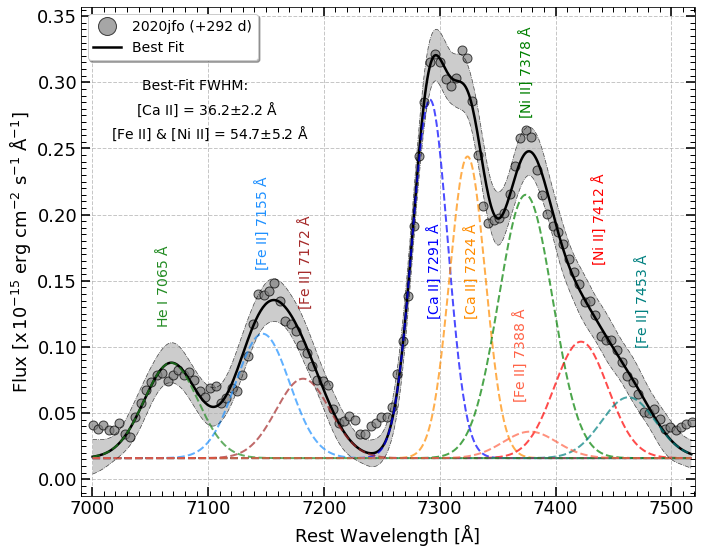

In [21]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
feature = 'CaIIDouble'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 18, 20]]
err1 = [round(err[index], 3) for index in [0, 1, 18, 20]]
opt2 = [round(opt[index], 3) for index in [2, 3, 18, 20]]
err2 = [round(err[index], 3) for index in [2, 3, 18, 20]]
opt3 = [round(opt[index], 3) for index in [4, 5, 19, 20]]
err3 = [round(err[index], 3) for index in [4, 5, 19, 20]]
opt4 = [round(opt[index], 3) for index in [6, 7, 19, 20]]
err4 = [round(err[index], 3) for index in [6, 7, 19, 20]]
opt5 = [round(opt[index], 3) for index in [8, 9, 19, 20]]
err5 = [round(err[index], 3) for index in [8, 9, 19, 20]]
opt6 = [round(opt[index], 3) for index in [10, 11, 19, 20]]
err6 = [round(err[index], 3) for index in [10, 11, 19, 20]]
opt7 = [round(opt[index], 3) for index in [12, 13, 19, 20]]
err7 = [round(err[index], 3) for index in [12, 13, 19, 20]]
opt8 = [round(opt[index], 3) for index in [14, 15, 19, 20]]
err8 = [round(err[index], 3) for index in [14, 15, 19, 20]]
opt9 = [round(opt[index], 3) for index in [16, 17, 19, 20]]
err9 = [round(err[index], 3) for index in [16, 17, 19, 20]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)
print (opt4, err4)
print (opt5, err5)
print (opt6, err6)
print (opt7, err7)
print (opt8, err8)
print (opt9, err9)

ca7291 = calc_flux(opt1, err2, norm_factor)
ca7324 = calc_flux(opt2, err2, norm_factor)
ni7378 = calc_flux(opt3, err3, norm_factor)
ni7412 = calc_flux(opt4, err4, norm_factor)
fe7155 = calc_flux(opt6, err6, norm_factor)
fe7172 = calc_flux(opt7, err7, norm_factor)
temp = fsolve(calc_ejectatemp, x0 = 4000, args = (fe7155[0], mni))[0]
niferatio = calc_niferatio(ni7378[0], fe7155[0], temp)

print ("-" * 40)
print ("[CaII]-7291 = {0:.2e}+/-{1:.2e}".format(*ca7291))
print ("[CaII]-7324 = {0:.2e}+/-{1:.2e}".format(*ca7324))
print ("[NiII]-7378 = {0:.2e}+/-{1:.2e}".format(*ni7378))
print ("[NiII]-7412 = {0:.2e}+/-{1:.2e}".format(*ni7412))
print ("[FeII]-7155 = {0:.2e}+/-{1:.2e}".format(*fe7155))
print ("[FeII]-7172 = {0:.2e}+/-{1:.2e}".format(*fe7172))
print ("[NiII] 7412/7378 = {0:.2f}".format(ni7412[0]/ni7378[0]))
print ("[FeII] 7172/7155 = {0:.2f}".format(fe7172[0]/fe7155[0]))
print ("[NiII]7378 / [FeII]7155 = {0:.2f}".format(ni7378[0]/fe7155[0]))
print ("[NiII/FeII] Ratio = {0:.2f}".format(niferatio))
print ("-" * 40)

fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+292 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Best Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='darkorange', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='g', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt4), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt5), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt6), lw=2, ls='--', alpha=0.7, c='dodgerblue', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt7), lw=2, ls='--', alpha=0.7, c='brown', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt8), lw=2, ls='--', alpha=0.7, c='forestgreen', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt9), lw=2, ls='--', alpha=0.7, c='tomato', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=feature)

# ax.set_yticklabels([])
ax.set_xlim(6990, 7520)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.05, 0.005), xticks=(100, 10), fs=18)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
# ax.set_title(r'FWHM: [Ca II] = {0:.1f}$\pm${1:.1f} $\rm \AA$; [Fe II/Ni II] = {2:.1f}$\pm${3:.1f} $\rm \AA$'.format(opt[-3] * 2.3546, err[-3] * 2.3546, opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)

ax.text(0.10, 0.83, 'Best-Fit FWHM:', fontsize=14, color='k', transform=ax.transAxes)
ax.text(0.09, 0.78, r'[Ca II] = {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-3] * 2.3546, err[-3] * 2.3546), fontsize=14, color='k', transform=ax.transAxes)
ax.text(0.05, 0.73, r'[Fe II] & [Ni II] = {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=14, color='k', transform=ax.transAxes)

ax.text(0.12, 0.35, r"$\rm He\ I\ 7065\ \AA$", fontsize=14, color='forestgreen', rotation=90, transform=ax.transAxes)
ax.text(0.28, 0.47, r"$\rm [Fe\ II]\ 7155\ \AA$", fontsize=14, color='dodgerblue', rotation=90, transform=ax.transAxes)
ax.text(0.35, 0.39, r"$\rm [Fe\ II]\ 7172\ \AA$", fontsize=14, color='brown', rotation=90, transform=ax.transAxes)
ax.text(0.56, 0.37, r"$\rm [Ca\ II]\ 7291\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.62, 0.37, r"$\rm [Ca\ II]\ 7324\ \AA$", fontsize=14, color='darkorange', rotation=90, transform=ax.transAxes)
ax.text(0.71, 0.78, r"$\rm [Ni\ II]\ 7378\ \AA$", fontsize=14, color='g', rotation=90, transform=ax.transAxes)
ax.text(0.70, 0.20, r"$\rm [Fe\ II]\ 7388\ \AA$", fontsize=14, color='tomato', rotation=90, transform=ax.transAxes)
ax.text(0.83, 0.48, r"$\rm [Ni\ II]\ 7412\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.90, 0.31, r"$\rm [Fe\ II]\ 7453\ \AA$", fontsize=14, color='teal', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_CaIINiIIFitV2.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

### 9-Component Fit (Keeping line broadening of [CaII], [NiII] and [FeII] all different)

[0.262, 7290.089, 14.821, 0.016] [0.009, 0.833, 0.683, 0.006]
[0.256, 7321.962, 14.821, 0.016] [0.014, 1.99, 0.683, 0.006]
[0.21, 7371.0, 20.089, 0.016] [1.34, 47.067, 19.137, 0.006]
[0.091, 7419.214, 20.089, 0.016] [0.424, 60.308, 19.137, 0.006]
[0.053, 7462.981, 25.0, 0.016] [0.027, 12.039, 2.629, 0.006]
[0.088, 7148.512, 25.0, 0.016] [0.032, 9.067, 2.629, 0.006]
[0.056, 7180.0, 25.0, 0.016] [0.036, 10.543, 2.629, 0.006]
[0.068, 7068.373, 25.0, 0.016] [0.007, 2.07, 2.629, 0.006]
[0.036, 7394.965, 25.0, 0.016] [1.341, 724.638, 2.629, 0.006]
----------------------------------------
[CaII]-7291 = 9.73e-15+/-6.87e-16
[CaII]-7324 = 9.51e-15+/-6.80e-16
[NiII]-7378 = 1.06e-14+/-6.82e-14
[NiII]-7412 = 4.58e-15+/-2.18e-14
[FeII]-7155 = 5.51e-15+/-2.09e-15
[FeII]-7172 = 3.51e-15+/-2.29e-15
[NiII] 7412/7378 = 0.43
[FeII] 7172/7155 = 0.64
[NiII]7378 / [FeII]7155 = 1.92
[NiII/FeII] Ratio = 0.16
----------------------------------------


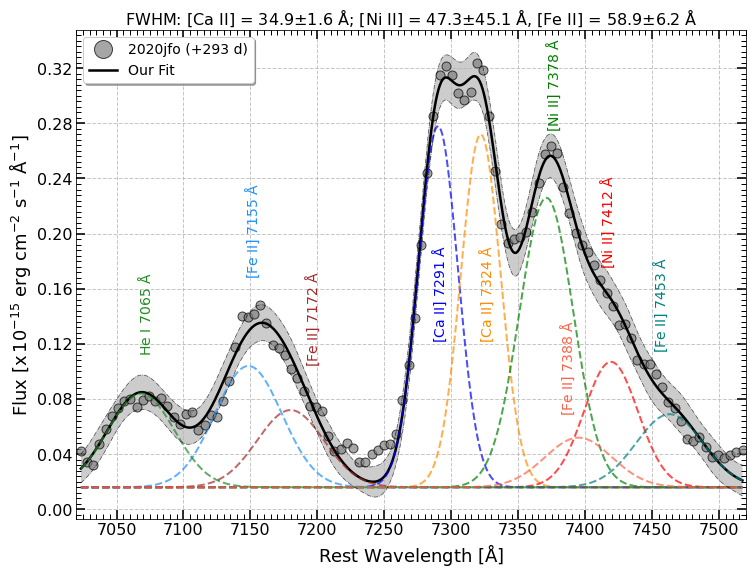

In [25]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
feature = 'CaIITriple'
wave_feature, wave_range, funcfit, guess, boundlow, boundhigh = dict_20jfo[feature]
wav, flux, fit_wav, opt, cov, err = fit_feature(wave_feature, func=funcfit)

opt1 = [round(opt[index], 3) for index in [0, 1, 18, 21]]
err1 = [round(err[index], 3) for index in [0, 1, 18, 21]]
opt2 = [round(opt[index], 3) for index in [2, 3, 18, 21]]
err2 = [round(err[index], 3) for index in [2, 3, 18, 21]]
opt3 = [round(opt[index], 3) for index in [4, 5, 19, 21]]
err3 = [round(err[index], 3) for index in [4, 5, 19, 21]]
opt4 = [round(opt[index], 3) for index in [6, 7, 19, 21]]
err4 = [round(err[index], 3) for index in [6, 7, 19, 21]]
opt5 = [round(opt[index], 3) for index in [8, 9, 20, 21]]
err5 = [round(err[index], 3) for index in [8, 9, 20, 21]]
opt6 = [round(opt[index], 3) for index in [10, 11, 20, 21]]
err6 = [round(err[index], 3) for index in [10, 11, 20, 21]]
opt7 = [round(opt[index], 3) for index in [12, 13, 20, 21]]
err7 = [round(err[index], 3) for index in [12, 13, 20, 21]]
opt8 = [round(opt[index], 3) for index in [14, 15, 20, 21]]
err8 = [round(err[index], 3) for index in [14, 15, 20, 21]]
opt9 = [round(opt[index], 3) for index in [16, 17, 20, 21]]
err9 = [round(err[index], 3) for index in [16, 17, 20, 21]]

print (opt1, err1)
print (opt2, err2)
print (opt3, err3)
print (opt4, err4)
print (opt5, err5)
print (opt6, err6)
print (opt7, err7)
print (opt8, err8)
print (opt9, err9)

ca7291 = calc_flux(opt1, err2, norm_factor)
ca7324 = calc_flux(opt2, err2, norm_factor)
ni7378 = calc_flux(opt3, err3, norm_factor)
ni7412 = calc_flux(opt4, err4, norm_factor)
fe7155 = calc_flux(opt6, err6, norm_factor)
fe7172 = calc_flux(opt7, err7, norm_factor)
temp = fsolve(calc_ejectatemp, x0 = 4000, args = (fe7155[0], mni))[0]
niferatio = calc_niferatio(ni7378[0], fe7155[0], temp)

print ("-" * 40)

print ("[CaII]-7291 = {0:.2e}+/-{1:.2e}".format(*ca7291))
print ("[CaII]-7324 = {0:.2e}+/-{1:.2e}".format(*ca7324))
print ("[NiII]-7378 = {0:.2e}+/-{1:.2e}".format(*ni7378))
print ("[NiII]-7412 = {0:.2e}+/-{1:.2e}".format(*ni7412))
print ("[FeII]-7155 = {0:.2e}+/-{1:.2e}".format(*fe7155))
print ("[FeII]-7172 = {0:.2e}+/-{1:.2e}".format(*fe7172))
print ("[NiII] 7412/7378 = {0:.2f}".format(ni7412[0]/ni7378[0]))
print ("[FeII] 7172/7155 = {0:.2f}".format(fe7172[0]/fe7155[0]))
print ("[NiII]7378 / [FeII]7155 = {0:.2f}".format(ni7378[0]/fe7155[0]))
print ("[NiII/FeII] Ratio = {0:.2f}".format(niferatio))
print ("-" * 40)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+293 d)')
ax.plot(fit_wav, funcfit(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Our Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='darkorange', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt3), lw=2, ls='--', alpha=0.7, c='g', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt4), lw=2, ls='--', alpha=0.7, c='r', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt5), lw=2, ls='--', alpha=0.7, c='teal', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt6), lw=2, ls='--', alpha=0.7, c='dodgerblue', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt7), lw=2, ls='--', alpha=0.7, c='brown', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt8), lw=2, ls='--', alpha=0.7, c='forestgreen', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt9), lw=2, ls='--', alpha=0.7, c='tomato', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=feature)

# ax.set_yticklabels([])
ax.set_xlim(7020, 7520)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True, loc=2)
set_plotparams(ax, yticks=(0.04, 0.004), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'FWHM: [Ca II] = {0:.1f}$\pm${1:.1f} $\rm \AA$; [Ni II] = {2:.1f}$\pm${3:.1f} $\rm \AA$, [Fe II] = {4:.1f}$\pm${5:.1f} $\rm \AA$'.format(opt[-4] * 2.3546, err[-4] * 2.3546, opt[-3] * 2.3546, err[-3] * 2.3546, opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=16)

ax.text(0.09, 0.34, r"$\rm He\ I\ 7065\ \AA$", fontsize=14, color='forestgreen', rotation=90, transform=ax.transAxes)
ax.text(0.25, 0.50, r"$\rm [Fe\ II]\ 7155\ \AA$", fontsize=14, color='dodgerblue', rotation=90, transform=ax.transAxes)
ax.text(0.34, 0.32, r"$\rm [Fe\ II]\ 7172\ \AA$", fontsize=14, color='brown', rotation=90, transform=ax.transAxes)
ax.text(0.53, 0.37, r"$\rm [Ca\ II]\ 7291\ \AA$", fontsize=14, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.60, 0.37, r"$\rm [Ca\ II]\ 7324\ \AA$", fontsize=14, color='darkorange', rotation=90, transform=ax.transAxes)
ax.text(0.70, 0.80, r"$\rm [Ni\ II]\ 7378\ \AA$", fontsize=14, color='g', rotation=90, transform=ax.transAxes)
ax.text(0.72, 0.22, r"$\rm [Fe\ II]\ 7388\ \AA$", fontsize=14, color='tomato', rotation=90, transform=ax.transAxes)
ax.text(0.78, 0.52, r"$\rm [Ni\ II]\ 7412\ \AA$", fontsize=14, color='r', rotation=90, transform=ax.transAxes)
ax.text(0.86, 0.35, r"$\rm [Fe\ II]\ 7453\ \AA$", fontsize=14, color='teal', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_CaIINiIIFitV3.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

[0.081, 7149.933, 13.702, 0.05]
[0.037, 7178.457, 13.702, 0.05]
----------------------------------------
FeII-Flux = 2.065280498554984e-14
----------------------------------------


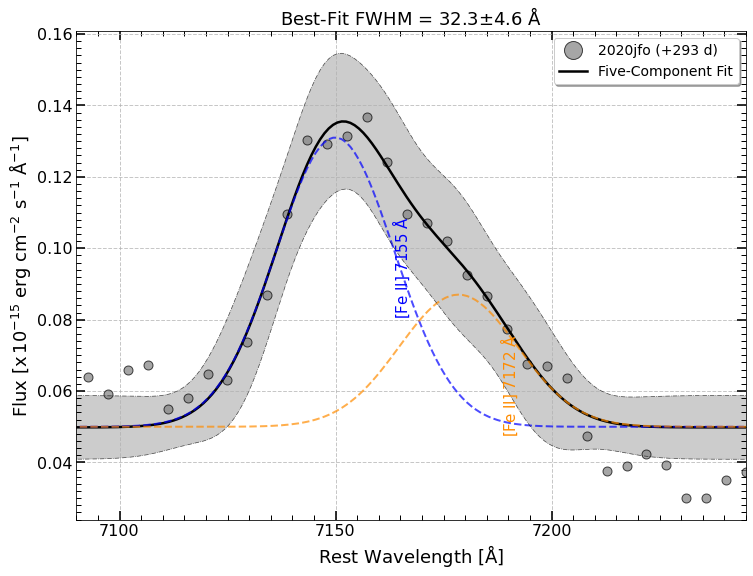

In [9]:
# !/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxx---------------------------PLOT 1-D SPECTRA---------------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import sys
import numpy as np
import pandas as pd
import uncertainties as unc
from astropy.io import fits
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit

from matplotlib import container
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
light_speed = 2.99792458e5  # In km/s
norm_factor = 1e-15

file_name = 'rrfz_2021-02-21_2020jfo.dat'
DIR_SPEC = '/home/avinash/Supernovae_Data/2020jfo/Spectroscopy/DOT/'
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plot Confidence Intervals
# Function For Setting Plot Parameters And Plotting
# ------------------------------------------------------------------------------------------------------------------- #

def plot_confintervals(ax_obj, optpar, covpar, xarr, fcolor='orange', components=5):
    """
    Plots 3-Sigma Confidence Intervals in Fits of SN Parameters.
    Args:
        ax_obj     : Axes object on which the confidence interval is to be plotted
        optpar     : Optimised Parameters of the Fit
        covpar     : Covariance Parameters of the Fit
        xarr       : Array of X-Values over which confidence intervals are to be plotted
        fcolor     : Fill color for the confidence intervals
        components : Number of gaussian components in the fit
    Returns:
        None
    """
    def err(xarr, h, c, w):
        return h * unp.exp(-(xarr - c) ** 2 / (2 * w ** 2))

    if components == 5:
        h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + err(xarr, h3, c3, w1) + \
               err(xarr, h4, c4, w1) + err(xarr, h5, c5, w1) + offset
    elif components == 2:
        h1, c1, h2, c2, w1, offset = unc.correlated_values(optpar, covpar)
        func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w1) + offset
    else:
        sys.exit(1)

    fit = unp.nominal_values(func)
    sigma = unp.std_devs(func)

    fitlow = fit - 3 * sigma
    fithigh = fit + 3 * sigma

    ax_obj.plot(xarr, fitlow, ls='-.', c='k', lw=0.7, alpha=0.7, label='_nolegend_')
    ax_obj.plot(xarr, fithigh, ls='-.', c='k', lw=0.7, alpha=0.7, label='_nolegend_')
    ax_obj.fill_between(xarr, fitlow, fithigh, facecolor=fcolor, alpha=0.4)


def set_plotparams(ax_obj, xticks=(50, 5), yticks=(1, 0.1), grid=True, legend=False, fs=14, ms=1.5):
    """
    Sets plot parameters to the axes object 'ax_obj'.
    Args:
        ax_obj      : Axes object to be used for plotting and setting plot parameters
        xticks      : X-Axis Major and Minor tick intervals
        yticks      : Y-Axis Major and Minor tick intervals
        grid        : Boolean stating whether to enable Grid in the plot
        legend      : Boolean stating whether legend is to be displayed in the plot
        fs          : Font of the labels in the legend
        ms          : Scaled marker size to be used in the legend
    Returns:
    """
    if legend:
        handles, labels = ax_obj.get_legend_handles_labels()
        handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
        ax_obj.legend(handles, labels, fontsize=fs, markerscale=ms, frameon=False)

    if grid:
        ax_obj.grid(True, which='major', ls='--', lw=1, alpha=0.7)

    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, color='k', 
                       labelcolor='k', labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, color='k', 
                       labelcolor='k', labelsize=fs)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Useful Functions For Fitting
# ------------------------------------------------------------------------------------------------------------------- #

def gaussian(x, height, center, width, offset):
    return height * np.exp(-(x - center) ** 2 / (2 * width ** 2)) + offset

def two_gaussians(x, h1, c1, h2, c2, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) + offset)

def five_gaussians(x, h1, c1, h2, c2, h3, c3, h4, c4, h5, c5, w1, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w1, offset=0) +
            gaussian(x, h3, c3, w1, offset=0) + gaussian(x, h4, c4, w1, offset=0) + 
            gaussian(x, h5, c5, w1, offset=0) + offset)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Read Data From The Spectrum to be Fitted
# ------------------------------------------------------------------------------------------------------------------- #
data_df = pd.read_csv(DIR_SPEC + file_name, sep='\s+', header=None, names=['Wavelength', 'Flux'], comment='#')
wav_data = np.array(data_df['Wavelength'])
flux_data = np.array(data_df['Flux']) / norm_factor
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Choose Region For Fitting & Fit The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
dict_20jfo = {'CaII': (7300, '7230,7520', [0.1, 7291, 0.1, 7324, 0.7, 7378, 0.1, 7430, 0.1, 7450, 13, 0.05],
                       [0.02, 7285, 0.02, 7315, 0.02, 7365, 0.02, 7400, 0.02, 7420, 10, 0.0],
                       [0.15, 7295, 0.15, 7335, 0.15, 7395, 0.15, 7450, 0.15, 7500, 20, 0.1]),
              '[FeII]': (7160, '7080, 7250', [0.05, 7155, 0.05, 7172, 10, 1], [0.02, 7125, 0.02, 7150, 5, 0.0],
                       [0.15, 7185, 0.15, 7200, 20, 0.1])}
feature = '[FeII]'
wave_feature, wave_range, guess, boundlow, boundhigh = dict_20jfo[feature]

wave_lim = wave_range.split(',')
lower_lim = int(wave_lim[0])
upper_lim = int(wave_lim[1])

flux = flux_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]
wav = wav_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]

fit_wav = np.arange(min(wav), max(wav), 1)
fit_vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in fit_wav])
vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in wav])

opt, cov = curve_fit(two_gaussians, wav, flux, bounds=(boundlow, boundhigh))
err = np.sqrt(np.diag(cov))

# opt1 = [round(opt[index], 3) for index in [0, 1, 10, 11]]
# cov1 = [round(err[index], 3) for index in [0, 1, 10, 11]]
# opt2 = [round(opt[index], 3) for index in [2, 3, 10, 11]]
# cov2 = [round(err[index], 3) for index in [2, 3, 10, 11]]
# opt3 = [round(opt[index], 3) for index in [4, 5, 10, 11]]
# cov3 = [round(err[index], 3) for index in [4, 5, 10, 11]]
# opt4 = [round(opt[index], 3) for index in [6, 7, 10, 11]]
# cov4 = [round(err[index], 3) for index in [6, 7, 10, 11]]
# opt5 = [round(opt[index], 3) for index in [8, 9, 10, 11]]
# cov5 = [round(err[index], 3) for index in [8, 9, 10, 11]]

# print (opt1)
# print (opt2)
# print (opt3)
# print (opt4)
# print (opt5)
# print ("-" * 40)
# print ("Ni-Flux = {0}".format(np.trapz((gaussian(fit_wav, *opt3) + gaussian(fit_wav, *opt4)) * norm_factor, x=fit_wav)))
# print ("-" * 40)

opt1 = [round(opt[index], 3) for index in [0, 1, 4, 5]]
cov1 = [round(err[index], 3) for index in [0, 1, 4, 5]]
opt2 = [round(opt[index], 3) for index in [2, 3, 4, 5]]
cov2 = [round(err[index], 3) for index in [2, 3, 4, 5]]

print (opt1)
print (opt2)
print ("-" * 40)
print ("FeII-Flux = {0}".format(np.trapz((gaussian(fit_wav, *opt2) + gaussian(fit_wav, *opt1)) * norm_factor, x=fit_wav)))
print ("-" * 40)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

ax.plot(wav, flux, c='k', mfc='grey', mew=1, ls='', marker='o', ms=9, alpha=0.7, label='2020jfo (+293 d)')
ax.plot(fit_wav, two_gaussians(fit_wav, *opt), lw=2.5, ls='-', c='k', label='Five-Component Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=2, ls='--', alpha=0.7, c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=2, ls='--', alpha=0.7, c='darkorange', label='_nolegend_')

plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey', components=2)

# ax.set_yticklabels([])
# ax.set_ylim(0., 0.1)
ax.set_xlim(7090, 7245)
ax.legend(markerscale=2, fontsize=14, frameon=True, fancybox=True, shadow=True)
set_plotparams(ax, yticks=(0.02, 0.002), xticks=(50, 5), fs=16)

ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
ax.set_ylabel(r'Flux [$\rm x\,10^{-15}\ erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)
ax.set_title(r'Best-Fit FWHM = {0:.1f}$\pm${1:.1f} $\rm \AA$'.format(opt[-2] * 2.3546, err[-2] * 2.3546), fontsize=18)

ax.text(0.47, 0.42, r"$\rm [Fe\ II]\ 7155\ \AA$", fontsize=15, color='b', rotation=90, transform=ax.transAxes)
ax.text(0.63, 0.18, r"$\rm [Fe\ II]\ 7172\ \AA$", fontsize=15, color='darkorange', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_CaIINiIIFit.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

## 5-Component Fit (All the parameters are free)


In [ ]:
# !/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxx---------------------------PLOT 1-D SPECTRA---------------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import numpy as np
import pandas as pd
import uncertainties as unc
from astropy.io import fits
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
light_speed = 2.99792458e5  # In km/s
norm_factor = 1e-15
file_name = 'r2020jfo.dat'
DIR_SPEC = '/home/avinash/Supernovae_Data/2020jfo/Spectroscopy/DOT/'

dict_17hcc = {'Halpha': (6562.81, r'H$\rm \alpha\ 6563\ \AA$', [1.4, 6562.81, 60, 2.2, 6562.81, 20, 0], '6475,6640'),
              'Hbeta': (4861.63, r'H$\rm \beta\ 4861\ \AA$', [1.1, 4861.63, 40, 1.4, 4861.63, 10, 0], '4800,4920')}
dict_12ab = {'Halpha': (6562.81, r'H$\rm \alpha\ 6563\ \AA$', [1.8, 6562.81, 60, 1.6, 6562.81, 20, 0], '6450,6660'),
             'Hbeta': (4861.63, r'H$\rm \beta\ 4861\ \AA$', [1.1, 4861.63, 40, 1.4, 4861.63, 10, 0], '4800,4920')}
dict_16gfy = {'Halpha': (6562.81, r'H$\rm \alpha\ 6563\ \AA$', [0.4, 6548, 5, 2.3, 6564, 5, 0.7, 6584, 5, 1],
              '6500,6620')}

dict_20jfo = {'CaII': (7300, '[Ca II] + [Ni II]', [0.1, 7291, 13, 0.1, 7324, 13, 0.7, 7378, 13, 0.1, 7439, 13, 0.1, 7450, 13, 0.05], '7230,7520')}
# 'FeII': (7155, '[Fe II]', [0.4, 7155, 5, 2.3, 6564, 5, 0.7, 6584, 5, 1], '7115,7195'),
feature = 'CaII'
wave_feature, title, guess_fit, wave_range = dict_20jfo[feature]
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plot Confidence Intervals
# ------------------------------------------------------------------------------------------------------------------- #

def plot_confintervals(ax_obj, optpar, covpar, xarr, fcolor='orange'):
    """
    Plots 3-Sigma Confidence Intervals in Fits of SN Parameters.
    Args:
        ax_obj  : Axes object on which the confidence interval is to be plotted
        optpar  : Optimised Parameters of the Fit
        covpar  : Covariance Parameters of the Fit
        xarr    : Array of X-Values over which confidence intervals are to be plotted
        fcolor  : Fill color for the confidence intervals
    Returns:
        None
    """
    def err(xarr, h, c, w):
        return h * unp.exp(-(xarr - c) ** 2 / (2 * w ** 2))

    h1, c1, w1, h2, c2, w2, h3, c3, w3, offset = unc.correlated_values(optpar, covpar)
    func = err(xarr, h1, c1, w1) + err(xarr, h2, c2, w2) + err(xarr, h3, c3, w3) + offset
    fit = unp.nominal_values(func)
    sigma = unp.std_devs(func)

    fitlow = fit - 3 * sigma
    fithigh = fit + 3 * sigma

    ax_obj.plot(xarr, fitlow, ls='-.', c='k', lw=0.7, alpha=0.5, label='_nolegend_')
    ax_obj.plot(xarr, fithigh, ls='-.', c='k', lw=0.7, alpha=0.5, label='_nolegend_')
    ax_obj.fill_between(xarr, fitlow, fithigh, facecolor=fcolor, alpha=0.3)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Useful Functions For Fitting
# ------------------------------------------------------------------------------------------------------------------- #

def gaussian(x, height, center, width, offset):
    return height * np.exp(-(x - center) ** 2 / (2 * width ** 2)) + offset


def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w2, offset=0) + offset


def three_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w2, offset=0) +
            gaussian(x, h3, c3, w3, offset=0) + offset)

def four_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, h4, c4, w4, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w2, offset=0) +
            gaussian(x, h3, c3, w3, offset=0) + gaussian(x, h4, c4, w4, offset=0) + offset)

def five_gaussians(x, h1, c1, w1, h2, c2, w2, h3, c3, w3, h4, c4, w4, h5, c5, w5, offset):
    return (gaussian(x, h1, c1, w1, offset=0) + gaussian(x, h2, c2, w2, offset=0) +
            gaussian(x, h3, c3, w3, offset=0) + gaussian(x, h4, c4, w4, offset=0) + 
            gaussian(x, h5, c5, w5, offset=0) + offset)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Read Data From The Normalised Spectra
# ------------------------------------------------------------------------------------------------------------------- #
data_df = pd.read_csv(DIR_SPEC + file_name, sep='\s+', header=None, names=['Wavelength', 'Flux'], comment='#')
wav_data = np.array(data_df['Wavelength'])
flux_data = np.array(data_df['Flux']) / norm_factor
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Choose Region For Fitting & Fit The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
# wave_lim = raw_input("Enter The Wavelength Range For The Spectral Line: {0}\r".format(wave_range)) or wave_range
wave_lim = wave_range.split(',')
lower_lim = int(wave_lim[0])
upper_lim = int(wave_lim[1])

usable_flux = flux_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]
usable_wav = wav_data[np.where((wav_data > lower_lim) & (wav_data < upper_lim))]

fit_wav = np.arange(min(usable_wav), max(usable_wav), 1)
fit_vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in fit_wav])
usable_vel = np.array([((wave - wave_feature) / (1000 * wave_feature)) * light_speed for wave in usable_wav])

# 0.4, 7291, 6, 2.3, 7324, 6, 0.7, 7378, 6, 0.05

plow = [0.05, 7280, 10, 0.05, 7315, 10, 0.05, 7370, 10, 0.05, 7430, 10, 0.05, 7390, 10, 0.0]
phigh = [0.15, 7400, 20, 0.15, 7335, 20, 0.15, 7390, 25, 0.15, 7450, 35, 0.15, 7420, 35,0.1]
opt, cov = curve_fit(five_gaussians, usable_wav, usable_flux, bounds=(plow, phigh))

err = np.sqrt(np.diag(cov))

opt1 = [abs(opt[index]) for index in [0, 1, 2, 15]]
cov1 = [abs(err[index]) for index in [0, 1, 2, 15]]
opt2 = [abs(opt[index]) for index in [3, 4, 5, 15]]
cov2 = [abs(err[index]) for index in [3, 4, 5, 15]]
opt3 = [abs(opt[index]) for index in [6, 7, 8, 15]]
cov3 = [abs(err[index]) for index in [6, 7, 8, 15]]
opt4 = [abs(opt[index]) for index in [9, 10, 11, 15]]
cov4 = [abs(err[index]) for index in [9, 10, 11, 15]]
opt5 = [abs(opt[index]) for index in [12, 13, 14, 15]]
cov5 = [abs(err[index]) for index in [12, 13, 14, 15]]

print(opt)
print(opt1)
print(opt2)
print(opt3)
print(opt4)
print(opt5)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plotting The Fit To The Spectral Feature
# ------------------------------------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.scatter(usable_wav, usable_flux, c='k', marker='x', s=40, label='Original Spectra')
ax.plot(fit_wav, five_gaussians(fit_wav, *opt), lw=2.5, ls='-', c='r', label='Triple Gaussian Fit')
ax.plot(fit_wav, gaussian(fit_wav, *opt1), lw=1.5, ls='--', c='b', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt2), lw=1.5, ls='--', c='darkorange', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt3), lw=1.5, ls='--', c='g', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt4), lw=1.5, ls='--', c='hotpink', label='_nolegend_')
ax.plot(fit_wav, gaussian(fit_wav, *opt5), lw=1.5, ls='--', c='teal', label='_nolegend_')

# plot_confintervals(ax, opt, cov, fit_wav, fcolor='grey')

# ax.set_yticklabels([])
# ax.set_xlim(6520, 6610)
# ax.legend(markerscale=2, fontsize=14, frameon=False)
# ax.xaxis.set_ticks_position('both')
# ax.yaxis.set_ticks_position('both')
# ax.yaxis.set_major_locator(MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_minor_locator(MultipleLocator(2))
# ax.tick_params(which='major', direction='in', width=1.4, length=8, labelsize=16)
# ax.tick_params(which='minor', direction='in', width=0.7, length=4, labelsize=16)

# ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=18)
# ax.set_ylabel(r'Flux [$\rm erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$]', fontsize=18)

# ax.text(0.29, 0.37, r"$\rm [N\,II]\ 6548\ \AA$", fontsize=16, color='b', rotation=90, transform=ax.transAxes)
# ax.text(0.49, 0.6, r"$\rm H\alpha$", fontsize=18, color='darkorange', rotation=90, transform=ax.transAxes)
# ax.text(0.71, 0.49, r"$\rm [N\,II]\ 6584\ \AA$", fontsize=16, color='g', rotation=90, transform=ax.transAxes)

fig.savefig('PLOT_SpecHostHalpha.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #